In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.patches as mpatches

In [2]:
pip install community 

In [3]:
df_review = pd.read_csv("yelp_academic_dataset_review.csv")
df_review = pd.DataFrame(df_review)

In [4]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [5]:
df_user = pd.read_csv("yelp_academic_dataset_user.csv")
df_user = pd.DataFrame(df_user)

C:\Users\asus\AppData\Local\Temp\ipykernel_8004\1230748970.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_user = pd.read_csv("yelp_academic_dataset_user.csv")


In [6]:
df_user.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946


In [7]:
pip install pandas networkx matplotlib


VAMOS CRIAR UMA COMUNIDADE DE USERS COM BASE NOS AMIGOS DELES :)))

In [8]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [9]:
import networkx as nx
import pandas as pd
from community import community_louvain
import matplotlib.pyplot as plt

In [24]:
# Define relevant categories
relevant_categories = {
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
}

df_restaurants = df_business[
    (df_business['city'] == 'Philadelphia') & 
    (df_business['categories'].str.contains('Restaurants', na=False))
]

df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in relevant_categories]
)

df_restaurants = df_restaurants[df_restaurants['relevant_categories'].str.len() > 0]

df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

# Limit 
first_users = df_filtered_reviews['user_id'].unique() ##########  [:100]
df_filtered_reviews = df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_users)]

# G = nx.Graph()

# for business_id, group in df_filtered_reviews.groupby('business_id'):
#     users = group['user_id'].tolist()
#     # Add edges between users who reviewed the same business using combinations
#     for user1, user2 in combinations(users, 2):
#         if G.has_edge(user1, user2):
#             G[user1][user2]['weight'] += 1
#         else:
#             G.add_edge(user1, user2, weight=1)

# plt.figure(figsize=(10, 10))
# pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
# nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
# plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
# plt.show()

# print("Number of nodes (users):", G.number_of_nodes())
# print("Number of edges (interactions):", G.number_of_edges())

C:\Users\asus\AppData\Local\Temp\ipykernel_8004\3512005786.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


Let's add the names of the people in the plot

In [30]:
relevant_categories = {
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
}

df_restaurants = df_business[ 
    (df_business['city'] == 'Philadelphia') & 
    (df_business['categories'].str.contains('Restaurants', na=False))
]

df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in relevant_categories]
)

df_restaurants = df_restaurants[df_restaurants['relevant_categories'].str.len() > 0]

df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

first_five_users = df_filtered_reviews['user_id'].unique() #####  [:2000]
df_filtered_reviews = df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_five_users)]


C:\Users\asus\AppData\Local\Temp\ipykernel_8004\1739395055.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


In [31]:
len(first_five_users)

2000

In [ ]:
G = nx.Graph()

for business_id, group in df_filtered_reviews.groupby('business_id'):
    users = group['user_id'].tolist()
    # Add edges between users who reviewed the same business using combinations
    for user1, user2 in combinations(users, 2):
        if G.has_edge(user1, user2):
            G[user1][user2]['weight'] += 1
        else:
            G.add_edge(user1, user2, weight=1)

df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, labels=user_names, font_size=10)

plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
plt.show()

print("Number of nodes (users):", G.number_of_nodes())
print("Number of edges (interactions):", G.number_of_edges())


Same but using the same style from the plot of the business

Detected Communities:
Community 1: {'1M1HMZO1_TuTS5tQbHKIgg', 'wABHp4fGUC-0acRKhmQO2A', 'au30JemWvCjjTp5vWdOLow', 'hWDybu_KvYLSdEFzGrniTw', '-5X3pQ0XrdZqNU1LHQPnpg', 'j6auVeGydK6FavvcyHu_Zw', 'ndgHYecgAWEqtjnjE7LtfA', 'qsKXDTwhbsZtogfaKIyfoQ', '98jv8gu7kAwa2WzIPdw6-w', 'TmdJhSSDABdUwuci8HhbBw', 'LqC5hNXcFVY-jcbyxi-tuQ', 'cARxOd_5yKCgsCbUZ5ED4Q', 'Xj4NPAq2efs4mzS4kFHGyQ', 'QvIZleI1KG46yFMRSWrYcQ', 'duJnzlaILBFufu1wjyu-Bg', 'eUta8W_HdHMXPzLBBZhL1A', 'Cvi8nZTwDVaQkqmmgQwQMw', 'uAu772KpSkb-tPFgZmU-lA', 'UYU71DRx-UDAee-eFOFfWw', '2XBcnIVhp_pEeer-asuxHA', 'Yr7tRi9b5-Na2FWP5ihG2A', 'M-00xuAOYLeaGEhPmmKjfg', 'vr-Rw3nMKIgGrVNT6A7p9g', 'EYg-VaZlk13-blZxyohLDg', 'kSMOJwJXuEUqzfmuFncK4A', 'zDWhnidBcEok7Vqnu-AnMg', 'Au2RZKzmrr75h2bBpb60oA', 'Zs8Zk3sgh5JxRmoZW4PJcg', 'dme9K6sQrgpojAay5r8IAA', 'gSEhdaQNcewg-ob6xSgleQ', 'FBRjdSizGuMyxQuSSwzarg', '4KNOhaUhegpmZ6sWwJtRTw', 'ZGjgfSvjQK886kiTzLwfLQ', 'ZPYPQvM1DMZB39oQ9WlDgw', 'g2GDpnMMXO9s0-JVIJnfzQ', 'tGMnQ1EnvZqpn_jAuN8VsA', 'tgZ0r69ap3_-sNBgLPZsPw', 'O

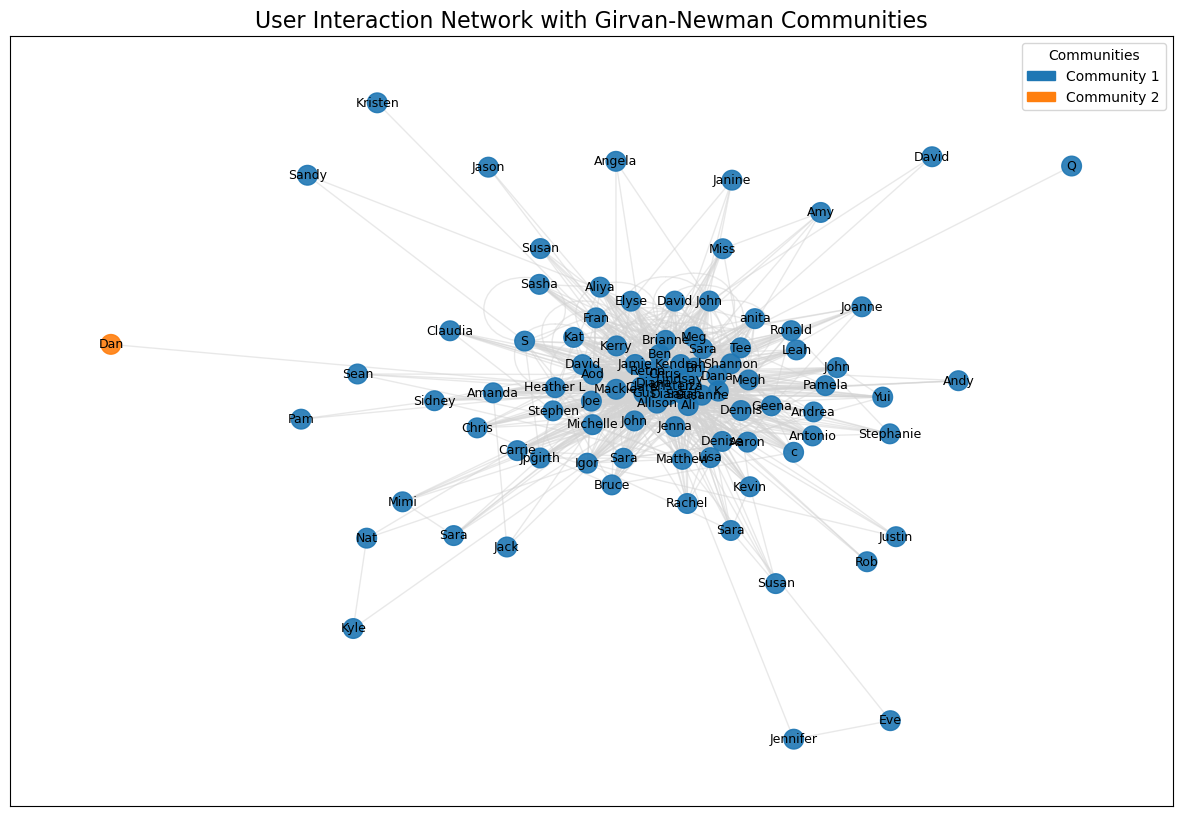

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming you have already created the user interaction network `G`
# Using the Girvan-Newman algorithm to detect communities
communities_generator = nx.community.girvan_newman(G)
first_community = next(communities_generator)  # Get the first set of communities
first_community = list(first_community)  # Convert to list format

# Print out the detected communities
print("Detected Communities:")
for i, community in enumerate(first_community):
    print(f"Community {i + 1}: {community}")

# Visualize the user interaction network with detected communities
plt.figure(figsize=(15, 10))

# Define distinct colors for communities
community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Map nodes to community colors
color_map = {}
for idx, community in enumerate(first_community):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  
# Get positions for nodes using spring layout
pos = nx.spring_layout(G, k=0.15, seed=42)  # Adjust k for spacing and seed for reproducibility

# Draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=200, alpha=0.9)

# Draw edges with a consistent color and transparency
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, alpha=0.5)
df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()
# Draw labels using the `user_names` 
nx.draw_networkx_labels(G, pos, labels=user_names, font_size=9, font_color='black')

# Title and layout
plt.title('User Interaction Network with Girvan-Newman Communities', fontsize=16)

# Create a legend for the communities
handles = []
for idx, community in enumerate(first_community):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)

# Display the legend
plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)

# Show the final plot
plt.show()


Again, Newman method is not good, so let's use the same used in Business

Detected Communities:
Community 1: ['mmdf_Fi-Hh_3uZN5zE164A', 'JDBlafv8p0UBtVFZ4LnRhw', 'Au2RZKzmrr75h2bBpb60oA', 'vqaJs9VyVLkbixSetsVKyQ', 'nBUnQnecIYYWuxk0g5njhw', '2DhNGmmyDmnZdZps49U9VQ', 'wABHp4fGUC-0acRKhmQO2A', 'gSEhdaQNcewg-ob6xSgleQ', '4KNOhaUhegpmZ6sWwJtRTw', 'hWDybu_KvYLSdEFzGrniTw', '-5X3pQ0XrdZqNU1LHQPnpg', 'ZPYPQvM1DMZB39oQ9WlDgw', 'av5_rihz1f5DLEIt5NrtNA', 'j6auVeGydK6FavvcyHu_Zw', 'g2GDpnMMXO9s0-JVIJnfzQ', 'qsKXDTwhbsZtogfaKIyfoQ', 'tgZ0r69ap3_-sNBgLPZsPw', '7ktyPHE-NGnWxarOqjIQiQ', '5kcLlhJPLJL_GLwrAdbZAA', 'BmThnFPDalpbC1x98aXKaw', 'QvIZleI1KG46yFMRSWrYcQ', 'RhqQNwLWCHArpTwhlaiM9A', 'aFa96pz67TwOFu4Weq5Agg', 'JW5W4OZCohTvZlRF1jzrTg', 'zg2FNzIq6s7n41H1E5NnWg', '2XBcnIVhp_pEeer-asuxHA', 'boC2VXdYY0bs4vOw_jD4bQ', 'i1jYqpHfyu2LB9c5zezLEQ', 'Yr7tRi9b5-Na2FWP5ihG2A', 'xE7AXFF9wVaN6id6OCtH3Q', 'JggphOM7FIbvUyPcsfcNTw', 'qz1XgXvvtRR8WKyWUXSJig']
Community 2: ['zDWhnidBcEok7Vqnu-AnMg', 'aWlojpSpzEICTza3RgGJgg', '1M1HMZO1_TuTS5tQbHKIgg', 'mNITUu6B2wUKBOa4NmUHJg', 'OfhZlqYMrCVAh

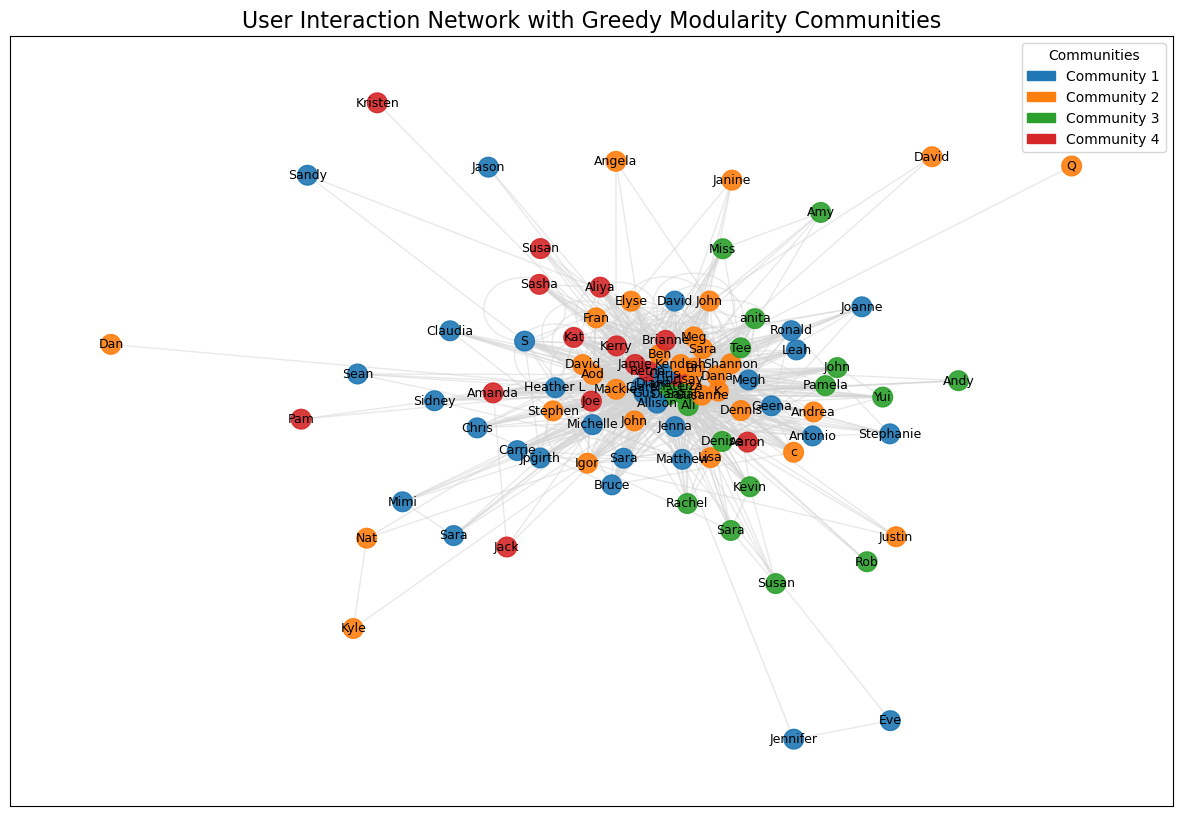

In [13]:


# Assuming the user interaction network `G` has already been created
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

print("Detected Communities:")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

plt.figure(figsize=(15, 10))

community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
                    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {}
for idx, community in enumerate(communities):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  # Cycle through colors

pos = nx.spring_layout(G, k=0.15, seed=42)  # Adjust k for spacing and seed for reproducibility

nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=200, alpha=0.9)

nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, alpha=0.5)

df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()

nx.draw_networkx_labels(G, pos, labels=user_names, font_size=9, font_color='black')

plt.title('User Interaction Network with Greedy Modularity Communities', fontsize=16)

handles = []
for idx, community in enumerate(communities):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)

plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)

plt.show()



I see a lot of circularity, so I want to get rid of it for simplicity

Detected Communities (after converting to directed graph):
Community 1: ['zDWhnidBcEok7Vqnu-AnMg', 'aWlojpSpzEICTza3RgGJgg', '1M1HMZO1_TuTS5tQbHKIgg', 'mNITUu6B2wUKBOa4NmUHJg', 'OfhZlqYMrCVAhM-bt_cQug', 'TmdJhSSDABdUwuci8HhbBw', '__GHy1xxetn0SBqP4b_odA', 'mzXDuhZBPdHfMIk1YXP0mQ', 'DEiAhP-xb4i-71foPKSqxQ', '11xwVSDv1ytjcyvUiyBWaw', 'QrVzVbFQ7vyePxrowVSe4w', 'AGyh5jnM0zrIElY7aZQafQ', 'dme9K6sQrgpojAay5r8IAA', 'ZINyxsYek_RF6jrUmQ_zDw', 'IQsF3Rc6IgCzjVV9DE8KXg', 'au30JemWvCjjTp5vWdOLow', 'ZGjgfSvjQK886kiTzLwfLQ', 'eUta8W_HdHMXPzLBBZhL1A', 'OkjeFppodgJP_CvB84cJYw', 'xjQSpme1Z7Xw8XehRLpYuA', '16yfdXvoj6ra0hqFjLu2cQ', 'uAu772KpSkb-tPFgZmU-lA', 'oMNtNOXYFN0qdSCSfOfTOg', 'ndgHYecgAWEqtjnjE7LtfA', '9oHOoqk-HlwDS2DlHLi_0g', 'tGMnQ1EnvZqpn_jAuN8VsA', 'XTWdXSOoUJnIMiVSA-1gDg', 'smOvOajNG0lS4Pq7d8g4JQ', 'mqBWACmaHflW4eh_Ofp16Q', 'HYvQKlH_LaPG8-FuJqTw1w', 'kSMOJwJXuEUqzfmuFncK4A', '_7bHUi9Uuf5__HHc_Q8guQ']
Community 2: ['mmdf_Fi-Hh_3uZN5zE164A', '7ktyPHE-NGnWxarOqjIQiQ', 'JDBlafv8p0UBtVFZ4LnRhw', 'Au

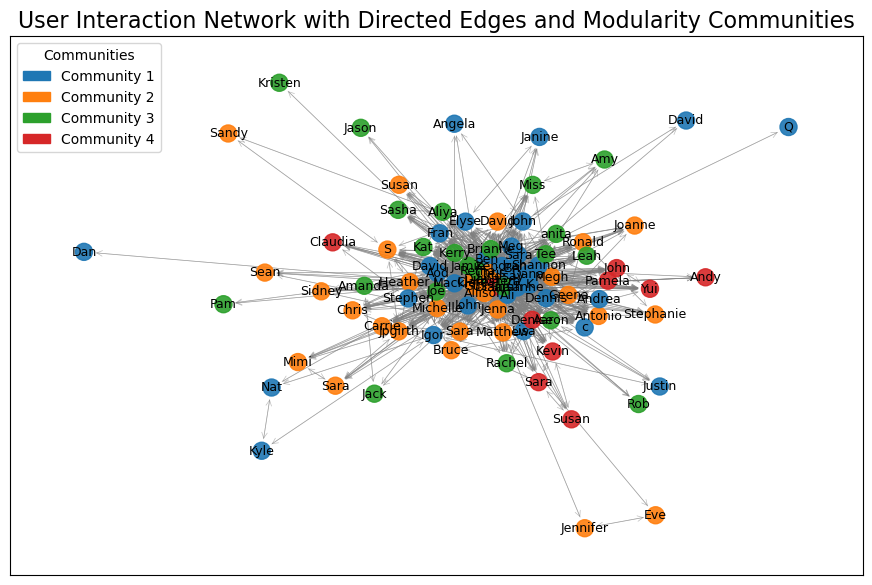

In [14]:
# Convert the graph to a directed graph to better represent direct interactions
# If you want to prune weak connections, consider converting to a directed graph (DiGraph)
G_directed = nx.DiGraph(G)  # Convert the existing graph to a directed one

# Optionally, remove self-loops (connections where a node connects to itself)
G_directed.remove_edges_from(nx.selfloop_edges(G_directed))

# Detect communities again in the new graph
communities = list(nx.algorithms.community.greedy_modularity_communities(G_directed))

print("Detected Communities (after converting to directed graph):")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

plt.figure(figsize=(11, 7))

community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {}
for idx, community in enumerate(communities):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  # Cycle through colors

pos = nx.spring_layout(G_directed, k=0.15, seed=42)  # Adjust `k` for spacing, `seed` for reproducibility

nx.draw_networkx_nodes(G_directed, pos, node_color=[color_map[node] for node in G_directed.nodes()],
                       node_size=150, alpha=0.9)

# Draw directed edges with arrows to show directionality
nx.draw_networkx_edges(G_directed, pos, edge_color='gray', arrows=True, arrowstyle='->', width=0.5, alpha=0.5)

df_user_subset = df_user[df_user['user_id'].isin(G_directed.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()
nx.draw_networkx_labels(G_directed, pos, labels=user_names, font_size=9, font_color='black')

plt.title('User Interaction Network with Directed Edges and Modularity Communities', fontsize=16)
handles = []
for idx, community in enumerate(communities):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)
plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)
plt.show()


Top, muito melhor! Mas agora não sei muito bem o que fazer com isto, vou ver as métricas:

In [16]:
degree_centrality = nx.degree_centrality(G_directed)
betweenness_centrality = nx.betweenness_centrality(G_directed)
closeness_centrality = nx.closeness_centrality(G_directed)

def print_top_centrality(centrality_dict, centrality_name):
    sorted_users = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    
    print(f"\n{centrality_name}:")
    for user_id, centrality in sorted_users[:5]: 
        user_name = user_names.get(user_id, user_id) 
        print(f"User: {user_name}, {centrality_name}: {centrality:.4f}")

print_top_centrality(degree_centrality, "Degree Centrality")
print_top_centrality(betweenness_centrality, "Betweenness Centrality")
print_top_centrality(closeness_centrality, "Closeness Centrality")



Degree Centrality:
User: Kristen, Degree Centrality: 1.4947
User: Gus, Degree Centrality: 1.3895
User: Diana, Degree Centrality: 1.3053
User: Clare, Degree Centrality: 1.3053
User: Chris, Degree Centrality: 1.3053

Betweenness Centrality:
User: Kristen, Betweenness Centrality: 0.0677
User: Mackie, Betweenness Centrality: 0.0631
User: Clare, Betweenness Centrality: 0.0592
User: Chris, Betweenness Centrality: 0.0560
User: Gus, Betweenness Centrality: 0.0525

Closeness Centrality:
User: Kristen, Closeness Centrality: 0.7983
User: Gus, Closeness Centrality: 0.7661
User: Diana, Closeness Centrality: 0.7422
User: Clare, Closeness Centrality: 0.7422
User: Chris, Closeness Centrality: 0.7422


In [20]:
# Assuming the user interaction network `G` has already been created
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

print("Detected Communities:")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {list(community)}")

# Calculate Degree Centrality for each node
degree_centrality = nx.degree_centrality(G)

Detected Communities:
Community 1: ['mmdf_Fi-Hh_3uZN5zE164A', 'JDBlafv8p0UBtVFZ4LnRhw', 'Au2RZKzmrr75h2bBpb60oA', 'vqaJs9VyVLkbixSetsVKyQ', 'nBUnQnecIYYWuxk0g5njhw', '2DhNGmmyDmnZdZps49U9VQ', 'wABHp4fGUC-0acRKhmQO2A', 'gSEhdaQNcewg-ob6xSgleQ', '4KNOhaUhegpmZ6sWwJtRTw', 'hWDybu_KvYLSdEFzGrniTw', '-5X3pQ0XrdZqNU1LHQPnpg', 'ZPYPQvM1DMZB39oQ9WlDgw', 'av5_rihz1f5DLEIt5NrtNA', 'j6auVeGydK6FavvcyHu_Zw', 'g2GDpnMMXO9s0-JVIJnfzQ', 'qsKXDTwhbsZtogfaKIyfoQ', 'tgZ0r69ap3_-sNBgLPZsPw', '7ktyPHE-NGnWxarOqjIQiQ', '5kcLlhJPLJL_GLwrAdbZAA', 'BmThnFPDalpbC1x98aXKaw', 'QvIZleI1KG46yFMRSWrYcQ', 'RhqQNwLWCHArpTwhlaiM9A', 'aFa96pz67TwOFu4Weq5Agg', 'JW5W4OZCohTvZlRF1jzrTg', 'zg2FNzIq6s7n41H1E5NnWg', '2XBcnIVhp_pEeer-asuxHA', 'boC2VXdYY0bs4vOw_jD4bQ', 'i1jYqpHfyu2LB9c5zezLEQ', 'Yr7tRi9b5-Na2FWP5ihG2A', 'xE7AXFF9wVaN6id6OCtH3Q', 'JggphOM7FIbvUyPcsfcNTw', 'qz1XgXvvtRR8WKyWUXSJig']
Community 2: ['zDWhnidBcEok7Vqnu-AnMg', 'aWlojpSpzEICTza3RgGJgg', '1M1HMZO1_TuTS5tQbHKIgg', 'mNITUu6B2wUKBOa4NmUHJg', 'OfhZlqYMrCVAh

In [21]:
community_metrics = {}

for i, community in enumerate(communities):
    community_centrality = [degree_centrality[node] for node in community]

    mean_community = sum(community_centrality) / len(community_centrality) if community_centrality else 0
    sum_community = sum(community_centrality)

    subgraph = G.subgraph(community)

    edges = subgraph.edges(data=True)
    total_weight = sum(edge[2]['weight'] for edge in edges)
    num_edges = len(edges)
    average_weight = total_weight / num_edges if num_edges > 0 else 0

    community_metrics[f"Community {i + 1}"] = {
        "Size": len(community),
        "Number of Edges": num_edges,
        "Total Weight": total_weight,
        "Average Weight": average_weight,
        "Mean Degree Centrality": mean_community,
        "Sum Degree Centrality": sum_community
    }

for community, metrics in community_metrics.items():
    print(f"\n{community}:")
    print(f"  Size: {metrics['Size']} nodes")
    print(f"  Number of Edges: {metrics['Number of Edges']}")
    print(f"  Total Weight of Edges: {metrics['Total Weight']:.2f}")
    print(f"  Average Weight of Edges: {metrics['Average Weight']:.2f}")
    print(f"  Mean Degree Centrality: {metrics['Mean Degree Centrality']:.4f}")
    print(f"  Sum of Degree Centrality: {metrics['Sum Degree Centrality']:.4f}")





Community 1:
  Size: 32 nodes
  Number of Edges: 155
  Total Weight of Edges: 603.00
  Average Weight of Edges: 3.89
  Mean Degree Centrality: 0.2309
  Sum of Degree Centrality: 7.3895

Community 2:
  Size: 31 nodes
  Number of Edges: 192
  Total Weight of Edges: 542.00
  Average Weight of Edges: 2.82
  Mean Degree Centrality: 0.2747
  Sum of Degree Centrality: 8.5158

Community 3:
  Size: 18 nodes
  Number of Edges: 64
  Total Weight of Edges: 322.00
  Average Weight of Edges: 5.03
  Mean Degree Centrality: 0.2503
  Sum of Degree Centrality: 4.5053

Community 4:
  Size: 15 nodes
  Number of Edges: 49
  Total Weight of Edges: 558.00
  Average Weight of Edges: 11.39
  Mean Degree Centrality: 0.2463
  Sum of Degree Centrality: 3.6947
